In [1]:
import warnings

import numpy as np

from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u
from astropy.utils.metadata import MergeConflictWarning
from astroquery.xmatch import XMatch
import healpy as hp
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import find_greedy_credible_levels
import pandas as pd
import matplotlib.pyplot as plt

import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.geom import degrees, SpherePoint

/home/s/sanand08/.local/lib/python3.12/site-packages/ligo/skymap/io/events/ligolw.py:26: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
repo = "/repo/embargo"
collection = "u/elhoward/TOO/S251112cm/Rubin-DECam/associated"
butler = Butler(repo, collections=collection)

In [3]:
data_refs = butler.query_datasets("dia_object",where="skymap in ('lsst_cells_v1','lsst_cells_v2')")

In [4]:
len(data_refs)

529

In [6]:
# Display columns in the DIA source catalog
dia_src = butler.get("dia_source", dataId=data_refs[10].dataId)
dia_src.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize',
       'timeProcessedMjdTai', 'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov',
       'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psfFlux',
       'psfFluxErr', 'psfChi2', 'psfNdata', 'trailFlux', 'trailFluxErr',
       'trailRa', 'trailDec', 'trailLength', 'trailAngle', 'dipoleMeanFlux',
       'dipoleMeanFluxErr', 'dipoleFluxDiff', 'dipoleFluxDiffErr',
       'dipoleLength', 'dipoleAngle', 'dipoleChi2', 'isDipole', 'isNegative',
       'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr',
       'templateFlux', 'templateFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF', 'extendedness', 'reliability', 'glint_trail',
       'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolated

In [7]:
# Display columns in DIA object catalog
dia_obj = butler.get(data_refs[10])
dia_obj.columns

Index(['ra', 'dec', 'nDiaSources', 'i_psfFluxMaxSlope', 'i_psfFluxErrMean',
       'i_psfFluxMean', 'i_psfFluxMeanErr', 'i_psfFluxNdata',
       'i_scienceFluxMean', 'i_scienceFluxMeanErr', 'i_psfFluxMin',
       'i_psfFluxMax', 'i_psfFluxSigma', 'g_psfFluxMaxSlope',
       'g_psfFluxErrMean', 'g_psfFluxMean', 'g_psfFluxMeanErr',
       'g_psfFluxNdata', 'g_scienceFluxMean', 'g_scienceFluxMeanErr',
       'g_psfFluxMin', 'g_psfFluxMax', 'g_psfFluxSigma'],
      dtype='object')

In [11]:
# create master dia source and dia object tables
dia_objs = []
for dr in data_refs:
    dia_src = butler.get("dia_source", dataId=dr.dataId)
    dia_obj = butler.get(dr)
    
    if len(dia_obj) < 1: 
        continue
            
    if len(dia_obj) < 1:
        continue
        
    elif len(dia_objs) < 1:
        dia_srcs = good_dia_src
        dia_objs = good_dia_obj
        
    else:
        dia_srcs = pd.concat([dia_srcs, dia_src])
        dia_objs = pd.concat([dia_objs, dia_obj])

In [12]:
dia_srcs

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,timeProcessedMjdTai,ra,...,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,pixelFlags_nodata,pixelFlags_nodataCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
25499902222532642,2025111600212,185,i,8574816307118084,0,0,60996.141567,19,61000.176313,33.657749,...,False,False,False,False,False,False,False,False,33.657749,-59.628654
25499902222532643,2025111600212,185,i,8574816307118085,0,0,60996.141567,16,61000.176313,33.640994,...,False,False,False,False,False,False,False,False,33.640994,-59.611196
25499902222532644,2025111600212,185,i,8574816307118086,0,0,60996.141567,16,61000.176313,33.642290,...,False,False,False,False,False,False,False,False,33.642290,-59.602621
25499902222532645,2025111600212,185,i,8574816307118087,0,0,60996.141567,15,61000.176313,33.640623,...,False,False,False,False,False,False,False,False,33.640623,-59.599322
25499902222532647,2025111600212,185,i,8574816307118088,0,0,60996.141567,21,61000.176313,33.611703,...,False,False,False,False,False,False,False,False,33.611703,-59.626341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25499889054515209,2025111600114,157,g,69971889199513601,0,0,60996.080974,68,61000.190182,339.032314,...,False,False,False,False,False,False,False,False,339.032314,3.219456
25499889054515203,2025111600114,157,g,69971957918990337,0,0,60996.080974,65,61000.190182,338.904992,...,False,False,False,False,False,False,False,False,338.904992,3.231761
25499889032495124,2025111600114,115,g,69972095357943809,0,0,60996.080974,59,61000.197510,338.522927,...,False,False,False,False,False,False,False,False,338.522927,3.226331


In [13]:
dia_objs

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
8574816307118084,33.657749,-59.628654,1,NaN,339.616821,-5339.174805,339.616821,1.0,23526.863281,348.402802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8574816307118085,33.640994,-59.611196,1,NaN,337.274780,-4011.716797,337.274811,1.0,23421.169922,346.197418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8574816307118086,33.642290,-59.602621,1,NaN,314.673096,-3757.288086,314.673096,1.0,10048.388672,322.975403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8574816307118087,33.640623,-59.599322,1,NaN,324.766754,-3728.368408,324.766754,1.0,17081.498047,333.357544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8574816307118088,33.611703,-59.626341,1,NaN,349.880157,-11026.145508,349.880157,1.0,22827.744141,359.620361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69971889199513601,339.032314,3.219456,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,474.577698,63814.535156,474.577698,1.0,291653.687500,501.576355,63814.535156,63814.535156,NaN
69971957918990337,338.904992,3.231761,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,252.649033,3410.629883,252.649033,1.0,35460.300781,266.945435,3410.629883,3410.629883,NaN
69972095357943809,338.522927,3.226331,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,240.100571,2769.785400,240.100571,1.0,20813.521484,254.588470,2769.785400,2769.785400,NaN


There are 1.5 million dia objects in this collection! Let's do some filtering:

In [9]:
"""
good = ~dia_src["slot_Shape_flag"] & \
    (dia_src["base_PsfFlux_instFlux"] / dia_src["base_PsfFlux_instFluxErr"] > snr_threshold) & \
    ~dia_src["base_PixelFlags_flag_edge"] & \
    ((dia_src_table["scienceFlux"] / dia_src_table["scienceFluxErr"]) < max_science_snr) & \
    ~dia_src_table["pixelFlags_streak"]
"""

def good_src_unfiltered(cat):
    """Good for the dia_source_unfiltered"""
    good = ~cat["slot_Shape_flag"] & \
        (cat["base_PsfFlux_instFlux"] / cat["base_PsfFlux_instFluxErr"] > snr_threshold) & \
        ~cat["base_PixelFlags_flag_edge"]

    good_cat = cat[good].copy()

    return good_cat

def good_src(cat):
    """Basic filtering criteria. Good for the dia_source tables"""
    good = ~cat["isDipole"] & ~cat["isNegative"] &\
        (cat["reliability"] > 0.1)
    good_cat = cat[good].copy()
    
    return good_cat

def good_obj(cat):
    """Require at least two detections in dia_object tables"""
    good = cat["nDiaSources"] > 1

    good_cat = cat[good].copy()

    return good_cat


In [26]:
# apply cuts above to dia objs and dia srcs
good_dia_srcs = good_src(dia_srcs)
good_dia_objs = good_obj(dia_objs)

In [27]:
good_dia_objs

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
8577633805664257,36.465145,-60.604419,2,NaN,330.397980,13416.397461,330.398010,1.0,36634.554688,340.452698,...,NaN,183.125885,-340.164734,183.125885,1.0,9447.605469,192.471497,-340.164734,-340.164734,NaN
8577633805664265,36.398297,-60.611189,2,NaN,295.287201,3304.961182,295.287201,1.0,7633.920898,304.047150,...,NaN,175.705093,-482.970428,175.705093,1.0,3890.145996,184.573151,-482.970428,-482.970428,NaN
8577633805664269,36.391252,-60.618925,2,NaN,323.481750,3156.253662,323.481750,1.0,27825.421875,333.083862,...,NaN,175.876007,-297.567719,175.876007,1.0,3992.940674,184.828400,-297.567719,-297.567719,NaN
8577633805664275,36.365143,-60.614202,2,NaN,300.633606,4382.465332,300.633606,1.0,10563.019531,309.366425,...,NaN,177.555176,7283.842773,177.555176,1.0,3966.204590,186.479645,7283.842285,7283.842285,NaN
8578321000431618,36.368163,-60.507494,2,NaN,303.163757,4276.637207,303.163757,1.0,10964.540039,311.643097,...,NaN,184.049927,3705.371582,184.049927,1.0,10709.261719,193.410187,3705.371338,3705.371338,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68312863592153091,339.448418,2.740452,2,NaN,379.144409,-4538.172363,379.144409,1.0,14957.824219,387.389587,...,NaN,235.646347,-3702.052490,235.646347,1.0,9954.068359,247.287567,-3702.052490,-3702.052490,NaN
68315955968606213,340.003168,1.833829,2,NaN,400.280823,-4778.730469,400.280823,1.0,6777.653809,410.290009,...,NaN,209.568481,-3103.483398,209.568481,1.0,3366.397949,219.025818,-3103.483154,-3103.483154,NaN
68316024688082947,339.946989,1.873576,2,NaN,437.273071,22971.183594,437.273071,1.0,41659.421875,449.779449,...,NaN,248.414749,21084.060547,248.414749,1.0,27883.445312,259.706940,21084.060547,21084.060547,NaN


In [44]:
# keep only dia objects for which good dia sources exist
common_dia_objids = set(good_dia_srcs['diaObjectId'].to_list()).intersection(set(good_dia_objs.index.to_list()))
dia_objs_filtered = good_dia_objs.loc[list(common_dia_objids)]

In [45]:
dia_objs_filtered

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
8577633805664257,36.465145,-60.604419,2,NaN,330.397980,13416.397461,330.398010,1.0,36634.554688,340.452698,...,NaN,183.125885,-340.164734,183.125885,1.0,9447.605469,192.471497,-340.164734,-340.164734,NaN
8578321000431618,36.368163,-60.507494,2,NaN,303.163757,4276.637207,303.163757,1.0,10964.540039,311.643097,...,NaN,184.049927,3705.371582,184.049927,1.0,10709.261719,193.410187,3705.371338,3705.371338,NaN
8579145634152449,35.789520,-60.257366,2,NaN,300.105164,3309.176270,300.105164,1.0,10869.881836,308.206665,...,NaN,170.702957,1864.831177,170.702957,1.0,5278.811035,179.239853,1864.831299,1864.831299,NaN
8580038987350018,34.645324,-60.242128,2,NaN,316.599915,4309.343262,316.599915,1.0,14025.710938,321.755341,...,NaN,198.286011,2369.938721,198.286011,1.0,10568.888672,209.170700,2369.938721,2369.938721,NaN
8579076914675717,35.893180,-60.365856,2,NaN,316.863220,4378.160156,316.863190,1.0,25472.253906,324.828186,...,NaN,191.101074,-435.059204,191.101074,1.0,18052.882812,201.004944,-435.059204,-435.059204,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19785849180782596,14.839014,-44.370707,2,NaN,311.076691,3369.683838,311.076691,1.0,16814.845703,318.409149,...,NaN,160.080505,-2107.062744,160.080505,1.0,9119.091797,165.447098,-2107.062744,-2107.062744,NaN
15229404275802124,17.420725,-50.497020,2,NaN,340.991547,-8167.636719,340.991547,1.0,45306.277344,348.467041,...,NaN,150.372589,2576.431641,150.372589,1.0,12059.820312,155.374390,2576.431641,2576.431641,NaN
19777877721481221,11.881316,-44.597975,2,NaN,332.419678,5211.338867,332.419678,1.0,41220.363281,342.435944,...,NaN,170.542908,6849.395996,170.542908,1.0,14173.000000,187.258865,6849.395996,6849.395996,NaN


## Inside-outside calculation

In [48]:
def in_skymap(skymap_prob, good_dia_obj, dataset_type="dia_object", contour = 0.95):
    ra_obj = good_dia_obj["ra"]
    dec_obj = good_dia_obj["dec"]
    npix = len(skymap_prob)
    nside = hp.npix2nside(npix)
    ipix = hp.ang2pix(nside, ra_obj, dec_obj, lonlat=True)
    credible_levels = find_greedy_credible_levels(skymap_prob)
    return credible_levels[ipix] <= contour

In [49]:
skymap = read_sky_map("../data/S251112cm_bilby.fits")
prob = skymap[0]
inside = in_skymap(prob, good_dia_obj=dia_objs_filtered, contour = 0.95)
dia_objs_inside = dia_objs_filtered[inside]

In [50]:
dia_objs_inside

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
8577633805664257,36.465145,-60.604419,2,NaN,330.397980,13416.397461,330.398010,1.0,36634.554688,340.452698,...,NaN,183.125885,-340.164734,183.125885,1.0,9447.605469,192.471497,-340.164734,-340.164734,NaN
8578321000431618,36.368163,-60.507494,2,NaN,303.163757,4276.637207,303.163757,1.0,10964.540039,311.643097,...,NaN,184.049927,3705.371582,184.049927,1.0,10709.261719,193.410187,3705.371338,3705.371338,NaN
8579145634152449,35.789520,-60.257366,2,NaN,300.105164,3309.176270,300.105164,1.0,10869.881836,308.206665,...,NaN,170.702957,1864.831177,170.702957,1.0,5278.811035,179.239853,1864.831299,1864.831299,NaN
8580038987350018,34.645324,-60.242128,2,NaN,316.599915,4309.343262,316.599915,1.0,14025.710938,321.755341,...,NaN,198.286011,2369.938721,198.286011,1.0,10568.888672,209.170700,2369.938721,2369.938721,NaN
8579076914675717,35.893180,-60.365856,2,NaN,316.863220,4378.160156,316.863190,1.0,25472.253906,324.828186,...,NaN,191.101074,-435.059204,191.101074,1.0,18052.882812,201.004944,-435.059204,-435.059204,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34563285458092036,357.058096,-28.788835,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-173857.670119,159.974457,2334.021240,113.116661,2.0,8462.026367,115.966774,2150.938232,2514.390381,256.999481
19785849180782596,14.839014,-44.370707,2,NaN,311.076691,3369.683838,311.076691,1.0,16814.845703,318.409149,...,NaN,160.080505,-2107.062744,160.080505,1.0,9119.091797,165.447098,-2107.062744,-2107.062744,NaN
19777877721481221,11.881316,-44.597975,2,NaN,332.419678,5211.338867,332.419678,1.0,41220.363281,342.435944,...,NaN,170.542908,6849.395996,170.542908,1.0,14173.000000,187.258865,6849.395996,6849.395996,NaN


In [51]:
dia_objs_inside.to_csv("../data/dia_obj_inside95_S251112cm.csv")

In [8]:
# if the csv is already created, load it
dia_objs_inside = pd.read_csv("../data/dia_obj_inside95_S251112cm.csv")

## NED-GWF galaxy crossmatch

In [52]:
# Load NED-GWF table
url = "https://ned.ipac.caltech.edu/uri/NED::GWFglist/fits/S251112cm/4"

ned_gwf = Table(fits.getdata(url))

In [53]:
ned_gwf

objname,ra,dec,objtype,z,z_unc,z_tech,z_qual,z_qual_flag,z_refcode,ziDist,ziDist_unc,ziDist_method,ziDist_indicator,ziDist_refcode,DistMpc,DistMpc_unc,DistMpc_method,ebv,A_FUV_MWext,A_NUV_MWext,A_J_MWext,A_H_MWext,A_Ks_MWext,A_W1_MWext,A_W2_MWext,A_W3_MWext,A_W4_MWext,m_FUV,m_FUV_unc,m_NUV,m_NUV_unc,Lum_FUV,Lum_FUV_unc,Lum_NUV,Lum_NUV_unc,GALEXphot,m_J,m_J_unc,m_H,m_H_unc,m_Ks,m_Ks_unc,Lum_J,Lum_J_unc,Lum_H,Lum_H_unc,Lum_Ks,Lum_Ks_unc,tMASSphot,m_W1,m_W1_unc,m_W2,m_W2_unc,m_W3,m_W3_unc,m_W4,m_W4_unc,Lum_W1,Lum_W1_unc,Lum_W2,Lum_W2_unc,Lum_W3,Lum_W3_unc,Lum_W4,Lum_W4_unc,WISEphot,SFR_W4,SFR_W4_unc,SFR_hybrid,SFR_hybrid_unc,ET_flag,Mstar,Mstar_unc,MLratio,P_2D,P_3D,P_2D_csum,P_3D_csum,P_Mstar,P_SFR,P_sSFR,P_LumW1,P_3D_Mstar,P_3D_SFR,P_3D_sSFR,P_3D_LumW1
str30,float64,float64,str6,float32,float32,str4,bool,bool,str19,float64,float64,str30,str1,str19,float32,float32,str30,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,str5,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,bool,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
AGC 208747,159.2775,20.5161111111111,G,0.00032689283,nan,UNKN,False,False,2016A&A...596A.117A,nan,nan,,,,1.4084027,nan,Redshift,0.019383822,0.1552131,0.17419715,0.015746957,0.009809612,0.006728239,0.003847457,0.0026839837,0.0010237546,0.0005326131,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,False,nan,nan,0.5,1.105000506557702,1.9688844829228506e-06,0.7095791258224945,0.5917971263975689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WISEA J013915.89-471751.8,24.8162476,-47.2977329,G,0.00054,0.000213,SPEC,False,False,1997AJ....114.1313C,nan,nan,,,,2.3269491,0.91746837,Redshift,0.012746077,0.102062345,0.11454555,0.010354611,0.0064504347,0.0044242386,0.002529944,0.0017648875,0.0006731828,0.00035022647,18.5441,0.0597547,18.2229,0.0352552,1.9534029466684373e+39,1.0751128615171526e+38,1.7762852484337926e+39,5.768010621731761e+37,ASC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,13.812,0.023,13.785,0.073,11.963,0.369,9.063,99.0,5.368503599881293e+38,1.1372900202386011e+37,2.2232108368809907e+38,1.4948363570663178e+37,8.731533184456437e+37,2.9676112951414574e+37,1.7435972343054267e+38,nan,APER,3.4063504186743166e-05,nan,0.00011631947236994556,nan,False,1698893.5442662318,35990.19051387978,0.5,2.294141496059659,1.0706827784233411e-06,0.5523232371090585,0.7362317337576566,9.644972019085916e-09,8.457623026546877e-09,5.7096645434090956e-05,9.524965514323448e-09,1.032670543921029e-14,9.055431320920437e-15,6.113239497202487e-11,1.0198216541262338e-14
GALEXASC J235059.08-264835.2,357.74679166667,-26.810416666669997,G,0.0006,0.000297,SPEC,True,True,20032dF...C...0000C,nan,nan,,,,2.5856192,1.2792869,Redshift,0.018108554,0.14500159,0.16273667,0.01471096,0.009164235,0.006285586,0.0035943314,0.0025074035,0.00095640146,0.0004975723,21.5012,0.345958,21.6129,0.320332,1.6469606468366552e+38,5.248035263440326e+37,1.0100544128882755e+38,2.980129881071741e+37,ASC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,False,nan,nan,0.5,3.19992875866416,2.0271092063679064e-06,0.44733279462273773,0.5854630746238607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UGC 07577,186.92042,43.495556,G,0.00065,1e-06,SPEC,False,False,2003A&A...401..483H,2.6443064212799072,0.031269438398829535,Wavg,P,Mix,2.6443064,0.03126944,zIndependent,0.017462263,0.1398265,0.15692863,0.014185928,0.008837165,0.0060612545,0.0034660504,0.0024179148,0.0009222676,0.000479814,15.018273,0.0008275661,14.63243,0.002857707,6.7185866035

In [54]:
def load_and_match_dia_obj_against_cat(cat, good_dia_obj, dataset_type="dia_object", radius=30 * u.arcsec, debug=False):
    
    dia_coord = SkyCoord(np.array(good_dia_obj["ra"]) * u.deg, np.array(good_dia_obj["dec"]) * u.deg)
    cat_coord = SkyCoord(cat["ra"] * u.deg, cat["dec"] * u.deg)
    
    idx, sep2d, _ = dia_coord.match_to_catalog_sky(cat_coord)

    close_enough = sep2d < radius
    matching_idx = idx[close_enough]

    if debug:
        print(len(dia_coord))
        print(cat_coord[364])
        print(idx)
        print(sep2d)
        print(matching_idx)
        print("----")

    matched_dia_obj = good_dia_obj[close_enough].copy()
    matched_cat = cat[matching_idx].copy()

    return matched_dia_obj, matched_cat
    

In [55]:
# Use an approximate matching radius given redshift.
z = z_at_value(cosmo.luminosity_distance, 93 * u.Mpc)
matching_radius_physical = 50 * u.kpc
matching_radius_angular = matching_radius_physical * cosmo.arcsec_per_kpc_proper(z)
print(matching_radius_physical, matching_radius_angular)

50.0 kpc 115.52553420764819 arcsec


In [56]:
# So let's call that 116"
ned_matching_radius = 116 * u.arcsec

In [57]:
ned_dia_obj_match, ned_cat_match = load_and_match_dia_obj_against_cat(ned_gwf, dia_objs_inside, dataset_type="dia_object", radius=ned_matching_radius)

In [58]:
ned_dia_obj_match

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
11255082058252346,39.328807,-55.239719,2,1.292972e+06,319.457703,3.498287e+03,225.665527,2.0,1.441357e+04,231.597565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10316374006038595,35.307519,-57.749054,2,3.214434e+06,360.676025,7.600723e+03,252.893066,2.0,3.839409e+04,260.552032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19800348990374235,18.584639,-44.072763,2,NaN,377.950439,3.933136e+03,377.950439,1.0,3.036299e+04,387.495331,...,NaN,183.050079,16758.539062,183.050079,1.0,9.020616e+03,190.848694,16758.539062,16758.539062,NaN
17451723433967757,16.826403,-46.826682,3,-1.082016e+07,355.761963,1.114048e+04,249.800613,2.0,3.342446e+04,256.990936,...,NaN,165.049316,-256.943146,165.049316,1.0,2.030889e+04,172.143509,-256.943146,-256.943146,NaN
17451723433967760,16.803950,-46.841998,2,NaN,361.698334,1.970778e+03,361.698334,1.0,2.404675e+04,372.500824,...,NaN,144.124146,1685.062988,144.124146,1.0,8.661652e+03,150.444138,1685.063110,1685.063110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19788048204038152,14.240344,-43.838657,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,678659.868056,537.057129,92169.265625,378.216980,2.0,5.217578e+05,397.702332,91664.859375,92790.476562,795.931519
28851734868656164,4.693134,-33.503735,2,NaN,334.597168,5.447528e+03,334.597168,1.0,1.260665e+04,346.908813,...,NaN,120.718079,-3.173547,120.718079,1.0,3.921292e+03,120.649788,-3.173547,-3.173547,NaN
37528668318203944,350.217106,-26.601102,2,NaN,401.177765,4.108703e+03,401.177765,1.0,5.259094e+03,414.292877,...,NaN,131.080536,1974.940186,131.080536,1.0,1.914635e+03,134.459137,1974.940308,1974.940308,NaN


In [59]:
ned_cat_match

objname,ra,dec,objtype,z,z_unc,z_tech,z_qual,z_qual_flag,z_refcode,ziDist,ziDist_unc,ziDist_method,ziDist_indicator,ziDist_refcode,DistMpc,DistMpc_unc,DistMpc_method,ebv,A_FUV_MWext,A_NUV_MWext,A_J_MWext,A_H_MWext,A_Ks_MWext,A_W1_MWext,A_W2_MWext,A_W3_MWext,A_W4_MWext,m_FUV,m_FUV_unc,m_NUV,m_NUV_unc,Lum_FUV,Lum_FUV_unc,Lum_NUV,Lum_NUV_unc,GALEXphot,m_J,m_J_unc,m_H,m_H_unc,m_Ks,m_Ks_unc,Lum_J,Lum_J_unc,Lum_H,Lum_H_unc,Lum_Ks,Lum_Ks_unc,tMASSphot,m_W1,m_W1_unc,m_W2,m_W2_unc,m_W3,m_W3_unc,m_W4,m_W4_unc,Lum_W1,Lum_W1_unc,Lum_W2,Lum_W2_unc,Lum_W3,Lum_W3_unc,Lum_W4,Lum_W4_unc,WISEphot,SFR_W4,SFR_W4_unc,SFR_hybrid,SFR_hybrid_unc,ET_flag,Mstar,Mstar_unc,MLratio,P_2D,P_3D,P_2D_csum,P_3D_csum,P_Mstar,P_SFR,P_sSFR,P_LumW1,P_3D_Mstar,P_3D_SFR,P_3D_sSFR,P_3D_LumW1
str30,float64,float64,str6,float32,float32,str4,bool,bool,str19,float64,float64,str30,str1,str19,float32,float32,str30,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,str5,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,bool,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
WISEA J023715.40-551433.6,39.3141865,-55.2426673,G,0.01921,0.00015,SPEC,False,False,20096dF...C...0000J,nan,nan,,,,83.96783,0.6461045,Redshift,0.02693031,0.2156405,0.2420154,0.021877544,0.013628679,0.009347669,0.0053453445,0.0037289092,0.0014223215,0.0007399694,18.1752,0.11109,17.5637,0.0524058,3.966755068059882e+42,4.058826706604703e+41,4.7734558011200067e+42,2.3041059047485446e+41,ASC,13.622,0.101,12.736,0.097,12.374,0.132,1.185033052465697e+43,1.1024070688457365e+42,1.2696336415385456e+43,1.134332402734778e+42,8.847902186552674e+42,1.075732745825922e+42,XSC,11.777,0.007,11.794,0.013,9.112,0.026,7.719,0.146,4.5670021988786134e+42,2.9445532664575385e+40,1.814755429581188e+42,2.1729594822203162e+40,1.5719608187064614e+42,3.7644817935501377e+40,7.831666263085021e+41,1.0531667344662165e+41,APER,0.15300207599150212,0.02057502086089248,0.30998667740247804,0.0254900280441415,False,14452538604.046244,93182065.3942259,0.5,0.8041034033517551,1.979555947869853e-06,0.7881299741101486,0.5905859800267159,8.205006776983826e-05,3.7988865558899704e-05,0.00010813855559073421,8.102916881553367e-05,1.6242269967690785e-10,7.520108476994812e-11,2.1406632091369265e-10,1.6040177307974007e-10
WISEA J022102.06-574412.5,35.2586191,-57.7368069,G,0.019137,0.00015,SPEC,False,False,20096dF...C...0000J,nan,nan,,,,83.64414,0.6461045,Redshift,0.02857479,0.22880843,0.25679392,0.023213482,0.014460905,0.009918478,0.005671754,0.003956612,0.0015091746,0.0007851551,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,12.96,0.018,13.05,0.051,10.145,0.076,8.394,99.0,1.5247787169302254e+42,2.5279556754355753e+40,5.664402144326097e+41,2.6608128410881967e+40,6.024508036293841e+41,4.2172109094066727e+40,4.1736600385431404e+41,nan,APER,0.08153803149016295,nan,nan,nan,False,4825249104.209574,79998597.32391061,0.5,0.2859629423233344,5.630433160746682e-07,0.9407210934805313,0.8516973294268717,2.7393942811950307e-05,2.0245067239409035e-05,6.774749884373711e-05,2.7053096687978174e-05,1.542397640120032e-11,1.1398849792631492e-11,3.814477640474249e-11,1.5232065269287855e-11
LCRS B011205.6-442032,18.5800274,-44.0776551,G,0.031592,0.00016,SPEC,False,False,1996ApJ...470..172S,nan,nan,,,,139.3724,0.68917805,Redshift,0.008645709,0.069229245,0.077696644,0.0070235687,0.0043753525,0.0030009765,0.0017160699,0.0011971293,0.00045662222,0.00023755983,nan,nan,nan,nan,nan,nan,nan,nan,,15.561,0.131,14.774,0.085,14.599,0.199,5.399044124905576e+42,6.514457998925729e+41,5.307684761223887e+42,4.155413092186002e+41,3.1219757752721227e+42,5.722327679091679e+41,PSC,14.353,0.039

In [61]:
ned_dia_obj_match.to_csv("../data/dia_obj_match_116arcsec_S251112cm.csv")

In [9]:
ned_dia_obj_match = pd.read_csv("../data/dia_obj_match_116arcsec_S251112cm.csv")

## WISE crossmatch

In [62]:
# check what Gaia DR3 catalogs are available in astroquery.XMatch using the CDS identifier
catalogs_available = XMatch.get_available_tables()
for name in catalogs_available:
    if "allwise" in name:
        print(name)

II/328/allwise
ii/328/allwise


In [65]:
def load_and_match_cat_against_wise(cat, good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = cat
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=cat, cat2="vizier:II/328/allwise", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table
    
def load_and_match_dia_obj_against_wise(good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=input_table, cat2="vizier:II/328/allwise", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table


In [66]:
# use 3.0 arcsec crossmatch radius between dia objects and WISE sources (nuclear to galaxies)
wise_table = load_and_match_dia_obj_against_wise(ned_dia_obj_match, radius = 3.0)

In [67]:
wise_table

angDist,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,i_psfFluxMin,i_psfFluxMax,i_psfFluxSigma,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma,diaObjectId,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,
float64,float64,float64,int16,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,str19,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str4,str1,str4,str4,int32,int32,int32,int32,float32
0.414733,39.32880650060126,-55.23971891755621,2,1292971.9296525752,319.45770263671875,3498.28662109375,225.66552734375,2.0,14413.568359375,231.59756469726562,3217.558349609375,3809.521484375,418.5811462402344,--,--,--,--,--,--,--,--,--,--,11255082058252346,J023718.93-551423.3,39.3289161,-55.2398157,0.2649,0.241,124.2,16.994,16.771,12.185,9.15,--,--,--,0.086,0.238,--,--,--,--,--,382054601351000607,0000,2,nnnn,ABUU,881,1171,-79,1138,--
0.989656,18.584638766152235,-44.07276326270479,2,--,377.950439453125,3933.13623046875,377.950439453125,1.0,30362.986328125,387.4953308105469,3933.13623046875,3933.13623046875,--,--,183.05007934570312,16758.5390625,183.05007934570312,1.0,9020.6162109375,190.84869384765625,16758.5390625,16758.5390625,--,19800348990374235,J011420.39-440421.4,18.584976,-44.0726333,0.2868,0.267,128.7,16.95,16.384,12.44,8.503,--,--,--,0.098,0.199,0.478,--,--,--,--,187044001351032833,0000,0,nnnn,ABCU,127,1216,422,1196,--
0.750277,16.826403393972388,-46.82668202567124,3,-10820156.881106798,355.761962890625,11140.482421875,249.8006134033203,2.0,33424.4609375,256.9909362792969,3458.406494140625,21244.703125,12576.810959876108,--,165.04931640625,-256.9431457519531,165.04931640625,1.0,20308.892578125,172.1435089111328,-256.9431457519531,-256.9431457519531,--,17451723433967757,J010718.37-464936.7,16.8265582,-46.8268615,0.1959,0.1808,126.6,16.503,15.988,12.001,9.049,--,--,--,0.068,0.142,--,--,--,--,--,174047001351035367,0000,0,0nnn,ABUU,43,794,522,779,--
0.945583,18.585112517511455,-44.04837079045512,2,--,323.0911865234375,-4572.466796875,323.0911865234375,1.0,21849.287109375,332.6094055175781,-4572.466796875,-4572.466796875,--,--,172.06256103515625,4126.978515625,172.06256103515625,1.0,1275.8592529296875,179.15455627441406,4126.978515625,4126.978515625,--,19801036185141411,J011420.33-440254.2,18.5847492,-44.0483992,0.5039,0.4486,131.9,17.532,17.396,12.428,9.031,--,--,--,0.157,0.525,--,--,--,--,--,187044001351033337,0000,0,nnnn,BCUU,-10899,2100,-2450,2038,--
0.540062,16.810752697425922,-46.84392969876972,2,-395930693.7675284,1401.032958984375,490934.125,981.77734375,2.0,2175451.0,1010.6075439453125,215678.09375,866513.4375,460210.0850015027,--,--,--,--,--,--,--,--,--,--,17451723433967791,J010714.62-465038.4,16.8109345,-46.8440136,0.0409,0.0374,67.8,11.631,11.654,10.404,8.842,13.389,12.822,12.295,0.023,0.021,0.086,--,0.06,0.087,0.05,174047001351034803,0000,5,001n,AAAU,-79,46,145,44,0.159
0.703243,10.406834107839599,-42.33956750594412,2,84658.43237932687,332.176025390625,3052.8359375,234.69801330566406,2.0,24236.55859375,242.87875366210938,1968.616943359375,4041.841796875,1465.991352845385,--,--,--,--,--,--,--,--,--,--,20990501607964860,J004137.63-422023.1,10.4067998,-42.3397612,0.1573,0.1431,133.4,16.055,15.724,12.798,9.145,--,--,--,0.054,0.125,--,--,--,--,--,101042501351030163,dd00,0,0nnn,ABUU,106,546,161,549,--
0.118691,25.541852074714736,-47.53321573715265,2,5665084.9176

We can draw conservative cuts on likely AGN hosts based on the WISE color-color diagram: https://www.astro-colibri.science/wisecolorcolordoc 

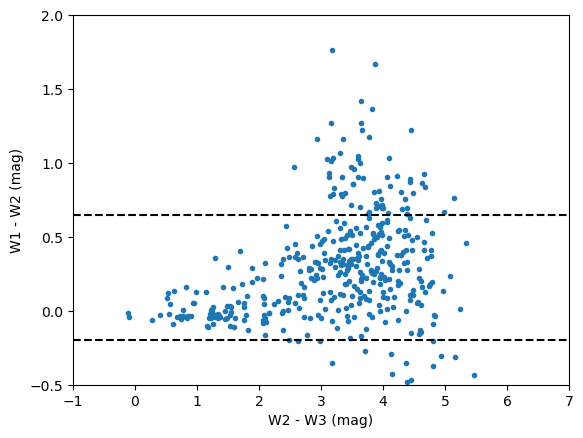

In [69]:
# plot crossmatched WISE galaxies on a color-color plot with conservative cuts on W1-w2 color
w1_w2 = np.array(wise_table['W1mag'] - wise_table['W2mag'])
w2_w3 = np.array(wise_table['W2mag'] - wise_table['W3mag'])
plt.figure()
plt.scatter(w2_w3, w1_w2, marker='.')
plt.xlabel('W2 - W3 (mag)')
plt.ylabel('W1 - W2 (mag)')
plt.axhline(0.65, linestyle='--', color='k')
plt.axhline(-0.2, linestyle='--', color='k')
plt.ylim(-0.5, 2)
plt.xlim(-1, 7)
plt.show()

In [70]:
# reject dia objects that are nuclear to probable AGN: matches falling outside of the boundary
mask = (w1_w2 > -0.2) & (w1_w2 < 0.65)
wise_table_filtered = wise_table[mask]
ned_dia_obj_filtered_wise = ned_dia_obj_match.loc[wise_table_filtered['diaObjectId']]

In [71]:
ned_dia_obj_filtered_wise

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
11255082058252346,39.328807,-55.239719,2,1.292972e+06,319.457703,3.498287e+03,225.665527,2.0,1.441357e+04,231.597565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19800348990374235,18.584639,-44.072763,2,NaN,377.950439,3.933136e+03,377.950439,1.0,3.036299e+04,387.495331,...,NaN,183.050079,16758.539062,183.050079,1.0,9.020616e+03,190.848694,16758.539062,16758.539062,NaN
17451723433967757,16.826403,-46.826682,3,-1.082016e+07,355.761963,1.114048e+04,249.800613,2.0,3.342446e+04,256.990936,...,NaN,165.049316,-256.943146,165.049316,1.0,2.030889e+04,172.143509,-256.943146,-256.943146,NaN
19801036185141411,18.585113,-44.048371,2,NaN,323.091187,-4.572467e+03,323.091187,1.0,2.184929e+04,332.609406,...,NaN,172.062561,4126.978516,172.062561,1.0,1.275859e+03,179.154556,4126.978516,4126.978516,NaN
17451723433967791,16.810753,-46.843930,2,-3.959307e+08,1401.032959,4.909341e+05,981.777344,2.0,2.175451e+06,1010.607544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17476118848208898,26.618948,-47.467679,2,NaN,820.316284,2.498054e+05,820.316284,1.0,7.063157e+05,842.133362,...,NaN,316.551392,1013.132263,316.551392,1.0,1.229581e+05,330.369598,1013.132263,1013.132263,NaN
36052505238437892,356.931052,-27.720293,2,NaN,452.800781,-3.489376e+03,452.800781,1.0,5.154537e+04,467.604248,...,NaN,138.970261,1423.365845,138.970261,1.0,6.029141e+03,142.063049,1423.365845,1423.365845,NaN
19788048204038152,14.240344,-43.838657,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,678659.868056,537.057129,92169.265625,378.216980,2.0,5.217578e+05,397.702332,91664.859375,92790.476562,795.931519


In [73]:
def load_and_match_dia_obj_against_milliquas(good_dia_obj, dataset_type="dia_object", radius= 3.0):

    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    wise_table = XMatch.query(cat1=input_table, cat2="vizier:VII/294/catalog", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return wise_table

In [74]:
milliquas_table = load_and_match_dia_obj_against_milliquas(ned_dia_obj_filtered_wise, radius = 3.0)

In [75]:
milliquas_table

angDist,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,i_psfFluxMin,i_psfFluxMax,i_psfFluxSigma,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma,diaObjectId,_RAJ2000,_DEJ2000,recno,RAJ2000,DEJ2000,Name,Type,Rmag,Bmag,Comment,R,B,z,rName,rz,XName,RName,Lobe1,Lobe2
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,mag,mag,,,,,,,,,,
float64,float64,float64,int16,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,float64,float64,int32,float64,float64,str25,str4,float32,float32,str3,str1,str1,float32,str6,str6,str22,str22,str22,str22
1.177544,20.081617389982615,-44.12842239230476,2,--,836.7240600585938,55221.6484375,836.7240600585938,1.0,958571.8125,856.4976196289062,55221.6484375,55221.6484375,--,--,451.61846923828125,83591.9375,451.61846923828125,1.0,415872.75,463.2701416015625,83591.9296875,83591.9296875,--,19807427096478307,20.0820183,-44.1285779,89596,20.0820183,-44.1285779,ESO 244-17,ARX,6.7,8.4,jG,1,1,0.023,PGC,1464,4XMM J012019.6-440742,RACD J012019.4-440741,SUMSS J012019.8-440741,1RXH J012019.3-440739
2.049162,3.107188456563336,-32.49716002720251,2,--,449.8197326660156,11660.283203125,449.81976318359375,1.0,205934.046875,464.07183837890625,11660.283203125,11660.283203125,--,--,228.8418426513672,2208.659912109375,228.8418426513672,1.0,100143.3046875,247.30799865722656,2208.659912109375,2208.659912109375,--,30244541223141378,3.1070834,-32.4977223,13372,3.1070834,-32.4977223,PGC 853,N,12.17,12.96,ba,-,-,0.025,PGC,6dAGN,,,,
0.24485,8.760359669945963,-43.57211070750292,3,1800254.57099818,310.786376953125,6521.482421875,218.51438903808594,2.0,19626.619140625,222.8527069091797,6000.50830078125,6928.6875,656.32177734375,--,178.64942932128906,6474.85986328125,178.64942932128906,1.0,13776.5078125,187.82347106933594,6474.859375,6474.859375,--,19767982116831234,8.760452,-43.572123,37568,8.760452,-43.572123,XMM J00350-4334,QX,21.0,21.77,D,-,n,1.594,0601,0601,CXOG J003502.4-433419,,2XMM J003502.4-433420,
0.89242,339.90087994760995,-0.6911230272951132,2,--,800.9609985351562,27611.466796875,800.9609985351562,1.0,527658.8125,819.9238891601562,27611.46875,27611.46875,--,--,326.68402099609375,6733.95751953125,326.68402099609375,1.0,149432.921875,340.4674377441406,6733.95751953125,6733.95751953125,--,64977769947201563,339.9010306,-0.6913199,949377,339.9010306,-0.6913199,PGC 1137099,N,11.84,14.86,p+,1,1,0.053,PGC,DR16,,,,
1.457101,358.09174915673515,-30.229918166234732,4,164242710.9106605,1112.6258544921875,114108.28125,616.964599609375,3.0,1226197.0,633.6036376953125,34022.0,327382.0,156487.71303143926,--,417.1686706542969,14750.6396484375,417.1686706542969,1.0,337142.375,428.1000061035156,14750.640625,14750.640625,--,33099835481522181,358.092,-30.23026,1013528,358.092,-30.23026,ESO 471-32,NR,10.09,11.73,p+e,-,-,0.029,PGC,2MAGN,,RACS J235221.7-301348,,


In [76]:
ned_dia_obj_nonAGN = ned_dia_obj_filtered_wise.drop(milliquas_table['diaObjectId'])

In [77]:
ned_dia_obj_nonAGN

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
11255082058252346,39.328807,-55.239719,2,1.292972e+06,319.457703,3.498287e+03,225.665527,2.0,1.441357e+04,231.597565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19800348990374235,18.584639,-44.072763,2,NaN,377.950439,3.933136e+03,377.950439,1.0,3.036299e+04,387.495331,...,NaN,183.050079,16758.539062,183.050079,1.0,9.020616e+03,190.848694,16758.539062,16758.539062,NaN
17451723433967757,16.826403,-46.826682,3,-1.082016e+07,355.761963,1.114048e+04,249.800613,2.0,3.342446e+04,256.990936,...,NaN,165.049316,-256.943146,165.049316,1.0,2.030889e+04,172.143509,-256.943146,-256.943146,NaN
19801036185141411,18.585113,-44.048371,2,NaN,323.091187,-4.572467e+03,323.091187,1.0,2.184929e+04,332.609406,...,NaN,172.062561,4126.978516,172.062561,1.0,1.275859e+03,179.154556,4126.978516,4126.978516,NaN
17451723433967791,16.810753,-46.843930,2,-3.959307e+08,1401.032959,4.909341e+05,981.777344,2.0,2.175451e+06,1010.607544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17476118848208898,26.618948,-47.467679,2,NaN,820.316284,2.498054e+05,820.316284,1.0,7.063157e+05,842.133362,...,NaN,316.551392,1013.132263,316.551392,1.0,1.229581e+05,330.369598,1013.132263,1013.132263,NaN
36052505238437892,356.931052,-27.720293,2,NaN,452.800781,-3.489376e+03,452.800781,1.0,5.154537e+04,467.604248,...,NaN,138.970261,1423.365845,138.970261,1.0,6.029141e+03,142.063049,1423.365845,1423.365845,NaN
19788048204038152,14.240344,-43.838657,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,678659.868056,537.057129,92169.265625,378.216980,2.0,5.217578e+05,397.702332,91664.859375,92790.476562,795.931519


## Gaia crossmatch

In [78]:
# check what Gaia DR3 catalogs are available in astroquery.XMatch using the CDS identifier
catalogs_available = XMatch.get_available_tables()
for name in catalogs_available:
    if "I/355" in name:
        print(name)

I/355/paramp
II/355/ugriz-2
I/355/xpsummary
I/355/paramsup
I/355/gaiadr3


In [79]:
def load_and_match_dia_obj_against_gaia(good_dia_obj, dataset_type="dia_object", radius= 3.0):
    
    input_table = Table.from_pandas(good_dia_obj)
    input_table['diaObjectId'] = good_dia_obj.index.to_list() # preserve diaObjectId
    gaia_table = XMatch.query(cat1=input_table, cat2="vizier:I/355/gaiadr3", max_distance=radius * u.arcsec, colRA1='ra', colDec1='dec')
    
    return gaia_table
    

In [80]:
# table of all gaia dr3 sources that crossmatch
gaia_match = load_and_match_dia_obj_against_gaia(ned_dia_obj_nonAGN, radius = 3.0)

In [81]:
gaia_match

angDist,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,i_psfFluxMin,i_psfFluxMax,i_psfFluxSigma,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma,diaObjectId,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,deg,,,,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,dex(cm / s2),dex,,km / s,km / s,,mag,mag,,,,,,,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,
float64,float64,float64,int16,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,str28,float64,float64,float32,float32,float32,int64,int64,int32,float32,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,uint8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,float32,int16,float32,float32,uint8,uint8,float32,uint8,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,int16,int16,int16,int16,uint8,float32,float32,float32,float32,float32,uint8,int16,int16,uint8,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,uint8,float32,float32,int16,float32,str13,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7,float64,float64,float64,float64,float32
0.472916,16.810752697425922,-46.84392969876972,2,-395930693.7675284,1401.032958984375,490934.125,981.77734375,2.0,2175451.0,1010.6075439453125,215678.09375,866513.4375,460210.0850015027,--,--,--,--,--,--,--,--,--,--,17451723433967791,Gaia DR3 4933266819929731456,16.81090222594,-46.84401214011,0.0,0.0,159.0,1636148068921376768,4933266819929731456,232704963,0.1947,0.2544,0.2259,0.3233,0.6985,0.788,-0.622,0.232,0.484,0.319,-0.2485,0.1223,-0.0412,0.084,-0.1275,0.0982,0.1046,-0.0126,-0.1803,-0.2689,578,0,574,4,39.7466,4142.3,3.146,98.562,95,False,--,1.3052,0.0577,-0.128,0.058,0.054,-0.058,0.005,67,30,0.459441,80,0.392,80.92,0,0,2.386,0,670,1478.34996,18.874,78.3275,17.762924,0.014133,70,4746.75,38.1051,124.57,16.14755,0.009152,68,9891.7,56.9045,173.83,14.759719,0.0073,9.902,0,31,0,29,0,1.387832,-1.615374,3.003205,--,--,0,0,0,0,--,--,--,--,--,--,--,--,0,--,--,0,--,--,0,--,NOT_AVAILABLE,0.0,1.0,0.0,--,--,--,--,--,--,--,--,--,--,--,-

In [82]:
gaia_match.columns

<TableColumns names=('angDist','ra','dec','nDiaSources','i_psfFluxMaxSlope','i_psfFluxErrMean','i_psfFluxMean','i_psfFluxMeanErr','i_psfFluxNdata','i_scienceFluxMean','i_scienceFluxMeanErr','i_psfFluxMin','i_psfFluxMax','i_psfFluxSigma','g_psfFluxMaxSlope','g_psfFluxErrMean','g_psfFluxMean','g_psfFluxMeanErr','g_psfFluxNdata','g_scienceFluxMean','g_scienceFluxMeanErr','g_psfFluxMin','g_psfFluxMax','g_psfFluxSigma','diaObjectId','DR3Name','RAdeg','DEdeg','errHalfMaj','errHalfMin','errPosAng','SolID','Source','RandomI','e_RAdeg','e_DEdeg','Plx','e_Plx','RPlx','PM','pmRA','e_pmRA','pmDE','e_pmDE','RADEcor','RAPlxcor','RApmRAcor','RApmDEcor','DEPlxcor','DEpmRAcor','DEpmDEcor','PlxpmRAcor','PlxpmDEcor','pmRApmDEcor','NAL','NAC','NgAL','NbAL','gofAL','chi2AL','epsi','sepsi','Solved','APF','nueff','pscol','e_pscol','RApscolCorr','DEpscolCorr','PlxpscolCorr','pmRApscolCorr','pmDEpscolCorr','MatchObsA','Nper','amax','MatchObs','IPDgofha','IPDgofhp','IPDfmp','IPDfow','RUWE','Dup','o_Gmag','FG','

In [83]:
# filter out sources likely to be stellar based on measured parallax (can change these cuts)
mask = (gaia_match['Plx'] is not None) & (gaia_match['e_Plx'] < 1.0)
gaia_stars = gaia_match[mask]

In [84]:
gaia_stars

angDist,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,i_psfFluxMin,i_psfFluxMax,i_psfFluxSigma,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma,diaObjectId,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,,,,mas,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,deg,,,,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,electron/s,electron/s,,mag,,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,dex(cm / s2),dex,,km / s,km / s,,mag,mag,,,,,,,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,
float64,float64,float64,int16,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,str28,float64,float64,float32,float32,float32,int64,int64,int32,float32,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,uint8,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,float32,int16,float32,float32,uint8,uint8,float32,uint8,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,float64,float32,float32,float32,float32,float32,int16,int16,int16,int16,uint8,float32,float32,float32,float32,float32,uint8,int16,int16,uint8,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,uint8,float32,float32,int16,float32,str13,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7,float64,float64,float64,float64,float32
0.472916,16.810752697425922,-46.84392969876972,2,-395930693.7675284,1401.032958984375,490934.125,981.77734375,2.0,2175451.0,1010.6075439453125,215678.09375,866513.4375,460210.0850015027,--,--,--,--,--,--,--,--,--,--,17451723433967791,Gaia DR3 4933266819929731456,16.81090222594,-46.84401214011,0.0,0.0,159.0,1636148068921376768,4933266819929731456,232704963,0.1947,0.2544,0.2259,0.3233,0.6985,0.788,-0.622,0.232,0.484,0.319,-0.2485,0.1223,-0.0412,0.084,-0.1275,0.0982,0.1046,-0.0126,-0.1803,-0.2689,578,0,574,4,39.7466,4142.3,3.146,98.562,95,False,--,1.3052,0.0577,-0.128,0.058,0.054,-0.058,0.005,67,30,0.459441,80,0.392,80.92,0,0,2.386,0,670,1478.34996,18.874,78.3275,17.762924,0.014133,70,4746.75,38.1051,124.57,16.14755,0.009152,68,9891.7,56.9045,173.83,14.759719,0.0073,9.902,0,31,0,29,0,1.387832,-1.615374,3.003205,--,--,0,0,0,0,--,--,--,--,--,--,--,--,0,--,--,0,--,--,0,--,NOT_AVAILABLE,0.0,1.0,0.0,--,--,--,--,--,--,--,--,--,--,--,-

In [85]:
# remove stellar sources from the crossmatched NED table
ned_dia_obj_filtered_gaia = ned_dia_obj_nonAGN.drop(gaia_stars['diaObjectId'])
ned_dia_obj_filtered_gaia

,ra,dec,nDiaSources,i_psfFluxMaxSlope,i_psfFluxErrMean,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxNdata,i_scienceFluxMean,i_scienceFluxMeanErr,...,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxNdata,g_scienceFluxMean,g_scienceFluxMeanErr,g_psfFluxMin,g_psfFluxMax,g_psfFluxSigma
diaObjectId,,,,,,,,,,,,,,,,,,,,,
11255082058252346,39.328807,-55.239719,2,1.292972e+06,319.457703,3498.286621,225.665527,2.0,14413.568359,231.597565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19800348990374235,18.584639,-44.072763,2,NaN,377.950439,3933.136230,377.950439,1.0,30362.986328,387.495331,...,NaN,183.050079,16758.539062,183.050079,1.0,9020.616211,190.848694,16758.539062,16758.539062,NaN
17451723433967757,16.826403,-46.826682,3,-1.082016e+07,355.761963,11140.482422,249.800613,2.0,33424.460938,256.990936,...,NaN,165.049316,-256.943146,165.049316,1.0,20308.892578,172.143509,-256.943146,-256.943146,NaN
19801036185141411,18.585113,-44.048371,2,NaN,323.091187,-4572.466797,323.091187,1.0,21849.287109,332.609406,...,NaN,172.062561,4126.978516,172.062561,1.0,1275.859253,179.154556,4126.978516,4126.978516,NaN
20990501607964860,10.406834,-42.339568,2,8.465843e+04,332.176025,3052.835938,234.698013,2.0,24236.558594,242.878754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17463405745012747,21.129237,-47.288655,2,NaN,317.792603,5235.083496,317.792603,1.0,31063.304688,326.707062,...,NaN,150.634918,3319.340088,150.634918,1.0,13339.472656,155.824158,3319.339844,3319.339844,NaN
17470758729023491,23.900355,-47.107229,2,NaN,513.613525,38070.343750,513.613525,1.0,252471.843750,526.348816,...,NaN,361.012756,-180.695770,361.012756,1.0,175013.984375,377.209076,-180.695770,-180.695770,NaN
28830637989298184,0.724686,-33.635313,2,NaN,390.201538,7812.134766,390.201538,1.0,74084.804688,402.206970,...,NaN,180.393906,2016.116333,180.393906,1.0,36542.917969,183.902176,2016.116333,2016.116333,NaN


In [ ]:
ned_dia_obj_filtered_gaia.to_csv("S251112dia_objects_

## Distance consistency (LS crossmatch / distant galaxies in the refcat)

If we are not limiting to objects falling in NED galaxies in the volume, we can also use basic cuts on the template image to rule out distant galaxies.

In [ ]:
# 0.8 " is a typical size for galaxy in Rubin
# 0.145 kpc / arcsec appropriate for the distance to the galaxy
# discard hosts that < 1 " across -- unlikely to be associated??